In [9]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
#from scipy.special import comb as C
#from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound, newton
#from scipy.signal import argrelextrema
import json
import itertools
from tqdm.notebook import tqdm
#from multiprocess import Pool

In [198]:
def pretty_std(x, std):
    prec = abs(int(np.log10(abs(std)))) + 1
    return '{:.{prec}f} & {:.{prec}f}'.format(x, std, prec=prec)

In [2]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift

    result = dict(sorted(result.items(), key=lambda item: item[0]))
    return {"S": result, "L": heat["L"]}

def calc_hc(st, T):

    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    E_qr = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
        E_qr += w * e * e * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

In [3]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DPotts/2DPotts{}_q{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, N, R, nSteps, seed)
    print(name)
    culling_factor = od()
    print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }


In [405]:
q = 20
;
L = 70
;
R = 131072;
seed_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9];
heat, cool = [{
    "q": q,
    "L": L,
    "R" : R,
    "nSteps" : 10,
    "seed" : seed,
    "heat": True
} for seed in seed_list], [{
    "q": q,
    "L": L,
    "R" : R,
    "nSteps" : 10,
    "seed" : seed,
    "heat": False
} for seed in seed_list]

parameters = []
for x in zip(cool, heat):
    parameters.append(read_tuple_files(x))

for i, x in enumerate(parameters):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])

./datasets/2DPotts/2DPotts_q20_N4900_R131072_nSteps10_run0X.txt
4900 131072 10 False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


./datasets/2DPotts/2DPottsHeating_q20_N4900_R131072_nSteps10_run0X.txt
4900 131072 10 True


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


./datasets/2DPotts/2DPotts_q20_N4900_R131072_nSteps10_run1X.txt
4900 131072 10 False
./datasets/2DPotts/2DPottsHeating_q20_N4900_R131072_nSteps10_run1X.txt
4900 131072 10 True
./datasets/2DPotts/2DPotts_q20_N4900_R131072_nSteps10_run2X.txt
4900 131072 10 False
./datasets/2DPotts/2DPottsHeating_q20_N4900_R131072_nSteps10_run2X.txt
4900 131072 10 True
./datasets/2DPotts/2DPotts_q20_N4900_R131072_nSteps10_run3X.txt
4900 131072 10 False
./datasets/2DPotts/2DPottsHeating_q20_N4900_R131072_nSteps10_run3X.txt
4900 131072 10 True
./datasets/2DPotts/2DPotts_q20_N4900_R131072_nSteps10_run4X.txt
4900 131072 10 False
./datasets/2DPotts/2DPottsHeating_q20_N4900_R131072_nSteps10_run4X.txt
4900 131072 10 True
./datasets/2DPotts/2DPotts_q20_N4900_R131072_nSteps10_run5X.txt
4900 131072 10 False
./datasets/2DPotts/2DPottsHeating_q20_N4900_R131072_nSteps10_run5X.txt
4900 131072 10 True
./datasets/2DPotts/2DPotts_q20_N4900_R131072_nSteps10_run6X.txt
4900 131072 10 False
./datasets/2DPotts/2DPottsHeating_q

In [100]:
[seed for seed in seed_list]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

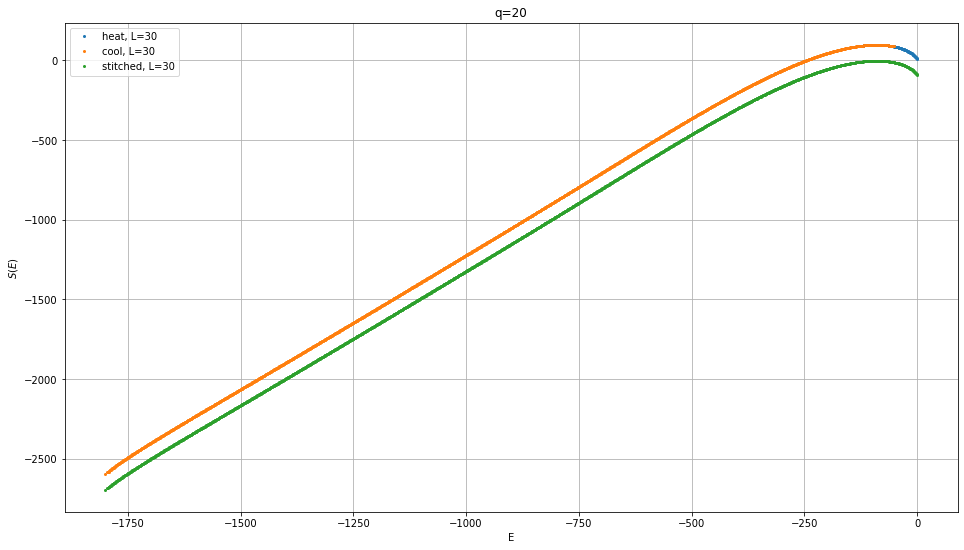

In [137]:
i = 0
heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]

plt.figure(figsize=(16, 9))

plt.plot([E for E in heat["S"]],
         [S + 100 for E, S in heat["S"].items()]
         , 'o', label="heat, L={}".format(cool["L"]), markersize=2)

plt.plot([E for E in cool["S"]],
         [S + 100 for E, S in cool["S"].items()]
         , 'o', label="cool, L={}".format(cool["L"]), markersize=2)

plt.plot([E for E in st["S"]],
         [S for E, S in st["S"].items()]
         , 'o', label="stitched, L={}".format(st["L"]), markersize=2)

plt.ylabel("$S(E)$")
plt.xlabel("E")

plt.title('q={}'.format(q))
plt.legend()
plt.grid()
#plt.savefig("./S_stitched(E)_D{}_L{}.png".format(heat["D"], heat["L"]))

In [385]:
import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [386]:
beta_0 = np.log(1 + np.sqrt(q))
beta_0, 1 / beta_0

(1.6996690255890117, 0.5883498404364079)

In [387]:
if q == 10:
    ec = (-1.664253 + -0.968203) / 2
elif q == 20:
    ec = (-1.82068 + -0.62653) / 2
ec

-1.223605

In [257]:
#with open('./tmp/2DPotts_Rc_L{}.txt'.format(10, L), 'w') as file:
#    file.write('mean={}, std={}'.format(np.mean(R_c), np.std(R_c)))

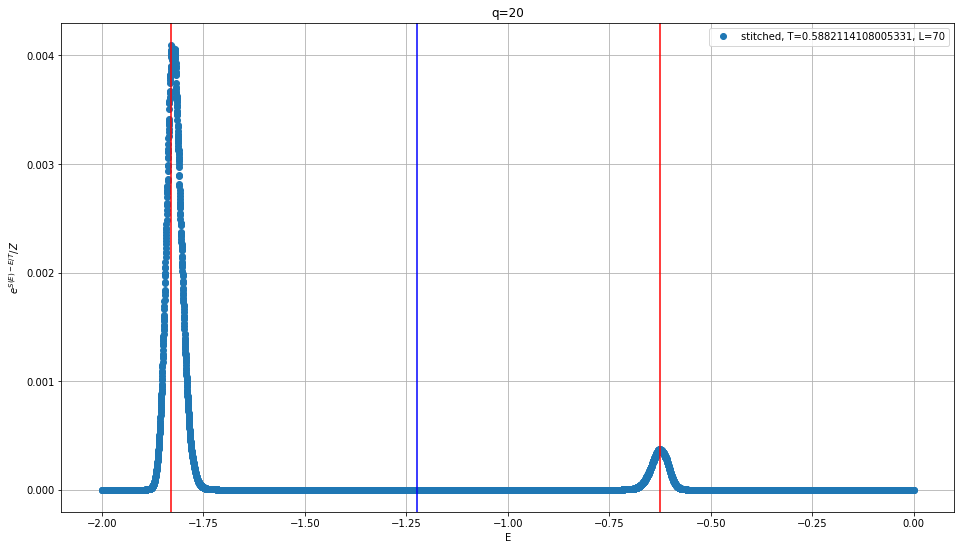

In [292]:
plt.figure(figsize=(16, 9))
i = 0
beta = beta_0 + 0.00040
heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]


y = np.array([mp.exp(mp.mpf(S) - mp.mpf(E) * beta) for E, S in st["S"].items()])
x = np.array([E / (L * L) for E in st["S"]])

plt.plot(x, y / sum(y), 'o', label="stitched, T={}, L={}".format(1/beta, L))

plt.ylabel('$e^{S(E) - E / T} / Z$')
plt.xlabel("E")
mask1 = x < ec;
mask2 = x > ec;

i1 = np.argmax(y[mask1])
i2 = np.argmax(y[mask2])

e1 = x[mask1][i1]
e2 = x[mask2][i2]

s1 = y[mask1][i1]
s2 = y[mask2][i2]
r = s1 / s2

plt.axvline(x = e1, color = 'r')
plt.axvline(x = ec, color = 'b')
plt.axvline(x = e2, color = 'r')
plt.title("q={}".format(q))
plt.legend()
plt.grid()

In [259]:
def f(beta):
    y = np.array([mp.exp(mp.mpf(S) - mp.mpf(E) * beta) for E, S in st["S"].items()])
    Z = sum(y)
    y /= Z;
    y = np.array(y, dtype=float)
    x = np.array([E / (L * L) for E in st["S"]])

    mask1 = x < ec;
    mask2 = x > ec;

    i1 = np.argmax(y[mask1])
    i2 = np.argmax(y[mask2])

    e1 = x[mask1][i1]
    e2 = x[mask2][i2]
    el = (e1 + e2) / 2

    s1 = y[mask1][i1]
    s2 = y[mask2][i2]
    peaks_ratio = s1 / s2

    return peaks_ratio, (e1, s1), (e2, s2), ( sum(y[x < el]) / sum(y[x > el]), sum(y[mask1]) / sum(y[mask2]))

Таблица 4:

In [260]:
results = []

for i in range(10):
    beta = beta_0
    st = parameters[i]["stitched"]
    
    results.append(f(beta_0))

In [252]:
print(
    L,
    beta,
    np.mean([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.mean([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.mean([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.mean([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.mean([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    sep=' & '
)

70 & 1.6996690255890117 & 59.631744843496236 & 104.36716394451994 & -1.8230816326530612 & 0.0018825355308704278 & -0.6253877551020408 & 0.0029393423489614268 & 54.82003045900426 & 94.87941740256709 & 54.820030459240115 & 94.8794174031003


In [32]:
[rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]

[8.030913310323399,
 7.462146338183195,
 7.599469348560646,
 8.88903578833373,
 8.638297001503778,
 8.193815708151552,
 7.947159193395229,
 7.338058656023545,
 8.753044066225232,
 8.025645185745772]

Таблица 5

In [293]:
target = 20
results_beta = []
results = []
#with open('./tmp/2DPottsCritical_q{}_L{}.txt'.format(q, L), 'a') as file:
for i in range(10):
    st = parameters[i]["stitched"]
    result_beta = newton(lambda x: f(x)[0] - target, beta_0 + 0.00040, full_output=True, tol=1e-07, disp=False)
    #print(result)
    #print(f(beta))
    #file.write('{} {}\n'.format(result[0], f(result[0])))
    beta = result_beta[0]
    results_beta.append(result_beta)
    results.append(f(beta))

In [294]:
[peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]

[20.000000067506708,
 20.00000002667549,
 20.000000067652262,
 20.000000012440136,
 20.000000038293326,
 20.00000021618379,
 20.000002554939627,
 20.00000000146868,
 20.000000446090088,
 20.00000119354858]

In [295]:
print(
    L,
    np.mean([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.mean([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    sep=' & '
)

print(
    L,
    np.mean([x[0] for x in results_beta]),
    np.std([x[0] for x in results_beta]),
#    np.mean([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.std([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.mean([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.mean([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.mean([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.std([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.mean([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    sep=' & ',
    end='\\\\\n'
)

print(
    L,
    pretty_std(
        np.mean([x[0] for x in results_beta]),
        np.std([x[0] for x in results_beta])
    ),
#    np.mean([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.std([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    pretty_std(
        np.mean([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
    pretty_std(
        np.mean([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
#    np.mean([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.std([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    pretty_std(
        np.mean([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
    sep=' & ',
    end='\\\\\n'
)

70 & 20.000000462479868 & 7.791404929510645e-07 & 18.330887168739928 & 0.873237088452249
70 & 1.699872634386463 & 0.0003925156091093326 & -1.824734693877551 & 0.002178613248176716 & -0.6258367346938776 & 0.002860348056399494 & 18.33088716875573 & 0.8732370884612064\\
70 & 1.6999 & 0.0004 & -1.825 & 0.002 & -0.626 & 0.003 & 18.3 & 0.9\\


In [306]:
target = 1
results_beta = []
results = []
#with open('./tmp/2DPottsCritical_q{}_L{}.txt'.format(q, L), 'a') as file:
for i in range(10):
    st = parameters[i]["stitched"]
    result_beta = newton(lambda x: f(x)[0] - target, beta_0, full_output=True)
    #print(result)
    beta = result_beta[0]
    #print(f(beta))
    #file.write('{} {}\n'.format(result[0], f(result[0])))
    results_beta.append(result_beta)
    results.append(f(beta))

In [308]:
[peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]

[1.000000000288784,
 1.0000000000175913,
 1.0000000000201041,
 1.0000000002973193,
 1.0000000561797149,
 1.0000000023043896,
 1.0000000854859217,
 1.0000000000409366,
 1.0000000000100717,
 1.0000000634378436]

In [307]:
print(
    L,
    np.mean([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.mean([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    np.std([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    sep=' & '
)

print(
    L,
    pretty_std(
        np.mean([x[0] for x in results_beta]),
        np.std([x[0] for x in results_beta])
    ),
#    np.mean([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.std([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    pretty_std(
        np.mean([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
    pretty_std(
        np.mean([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
#    np.mean([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.std([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    pretty_std(
        np.mean([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
    sep=' & ',
    end='\\\\'
)

70 & 1.0000000208082676 & 3.188104080933871e-08 & 0.9262401748477165 & 0.043864080316526666
70 & 1.6994 & 0.0004 & -1.822 & 0.002 & -0.625 & 0.002 & 0.93 & 0.04\\

In [303]:
#rc = 1
target = 20
results_beta = []
results = []
#with open('./tmp/2DPottsCritical_q{}_L{}.txt'.format(q, L), 'a') as file:
for i in range(10):
    st = parameters[i]["stitched"]
    result_beta = newton(lambda x: f(x)[3][1] - target, beta_0 + 0.00040, full_output=True)
    #print(result)
    beta = result_beta[0]
    #print(f(beta))
    #file.write('{} {}\n'.format(result[0], f(result[0])))
    results_beta.append(result_beta)
    results.append(f(beta))

In [304]:
[rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]

[20.000000074850544,
 20.000000063654902,
 20.000000074431124,
 20.00000000401548,
 20.000000066362446,
 19.99999999976823,
 20.000001028707295,
 20.00000000018419,
 20.0000000580341,
 20.0000014078922]

In [305]:
print(
    L,
    pretty_std(
        np.mean([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
    pretty_std(
        np.mean([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
    pretty_std(
        np.mean([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
    sep=' & '
)

print(
    L,
    pretty_std(
        np.mean([x[0] for x in results_beta]),
        np.std([x[0] for x in results_beta])
    ),
    pretty_std(
        np.mean([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([e1 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
    pretty_std(
        np.mean([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([e2 for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
#    np.mean([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.std([rl for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.mean([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
#    np.std([rc for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
    pretty_std(
        np.mean([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results]),
        np.std([peak_ratio for peak_ratio, (e1, s1), (e2, s2), (rl, rc) in results])
    ),
    sep=' & ',
    end='\\\\'
)

70 & 21.9 & 1.0 & 20.0000003 & 0.0000005 & 20.0000003 & 0.0000005
70 & 1.6999 & 0.0004 & -1.825 & 0.002 & -0.626 & 0.003 & 21.9 & 1.0\\

Таблица 6

In [388]:
def calc_hc(st, beta):
    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    E_qr = mp.mpf(0)
    Z = mp.mpf(0)
    L = st["L"]
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e * beta)
        Z += w
        E += w * e
        E_sq += w * e * e
        E_qr += w * e * e * e * e
    avgE = 1.0 * E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return beta, float( (avgE_sq - avgE * avgE) * (beta * beta) / (L * L) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

In [406]:
a = 1.6
b = 1.8
results_Bmin = []
for i, x in tqdm(enumerate(parameters), total=len(parameters)):
    st = x["stitched"]
    L = st["L"]
    beta, c, _, _ = fminbound(lambda beta: calc_hc(st, beta)[3], a, b, maxfun=500, full_output=1, disp=False)
    results_Bmin.append( calc_hc(st, beta) )

In [407]:
results_Cmax = []
for i, x in tqdm(enumerate(parameters), total=len(parameters)):
    st = x["stitched"]
    L = st["L"]
    beta, c, _, _ = fminbound(lambda beta: - calc_hc(st, beta)[1], a, b, maxfun=500, full_output=1, disp=False)
    results_Cmax.append( calc_hc(st, beta) )


In [408]:
print(
    L,
    pretty_std(
        np.mean([beta for beta, C, avgE, BC in results_Bmin]),
        np.std([beta for beta, C, avgE, BC in results_Bmin])
    ).split(' &')[0],
    pretty_std(
        np.mean([BC for beta, C, avgE, BC in results_Bmin]),
        np.std([BC for beta, C, avgE, BC in results_Bmin])
    ).split(' &')[0],
    pretty_std(
        np.mean([beta for beta, C, avgE, BC in results_Cmax]),
        np.std([beta for beta, C, avgE, BC in results_Cmax])
    ).split(' &')[0],
    pretty_std(
        np.mean([C for beta, C, avgE, BC in results_Cmax]),
        np.std([C for beta, C, avgE, BC in results_Cmax])
    ).split(' &')[0],
    sep=' & ',
    end='\\\\\n'
)

70 & 1.6990 & 0.117 & 1.6994 & 5052.9\\
